In [1]:
import numpy as np
import random
import torch
import importlib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import sys
sys.path.append('../')

from models.network import AutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def split(a, n):
    k, m = divmod(len(a), n)
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

## dataload
### create dataset
data_path = r'/path/to/datasets/shapenet/ShapeNetDepthCore.v2.h5/splitted/dataset_test.hdf5'

samples = ImNetImageSamples(
    data_path=data_path, use_depth=True, image_preferred_color_space=3, sample_class=True,
    label_txt_path=r'/path/to/datasets/shapenet/ShapeNetDepthCore.v2.h5/splitted/dataset_test.txt'
)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
is_svr = True
epoch = 1_000
use_phase = False
phase = 2

arc = '' # '_resnet50' or ''

testing_folder = r'./../pretrain/class_pretrain/' + (f'image_encoder{arc}/' if is_svr else 'phase_2_model')
config_path = os.path.join(testing_folder, 'config.py')
network_path = os.path.join(testing_folder, f'model_epoch{"_" + str(phase) if use_phase and not is_svr else ""}_{epoch}.pth')

## import config here
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [3]:
## loading index
sample_interval = 1
resolution = 64
max_batch = 20000
save_deformed = True
thershold = 0.01
with_surface_point = True

device_count = 1 # torch.cuda.device_count()
device_ratio = 1
worker_nums = int(device_count * device_ratio)
testing_cnt = 20

args = [(samples[i][0][0], resolution, max_batch, (-0.5, 0.5), thershold,
         samples.obj_paths[i], with_surface_point, i) for i in range(len(samples)) if
        i % sample_interval == 0]
random.shuffle(args)
args = args[:testing_cnt]
splited_args = split(args, worker_nums)
final_args = [(splited_args[i], network_path, config_path, i % device_count) for i in range(worker_nums)]

In [20]:
network_state_dict = torch.load(network_path)
network_state_dict, is_old_style_weights = AutoEncoder.process_state_dict(network_state_dict, type = 1)

if is_svr:
    #if is_old_style_weights and config.encoder_type.upper() == '3DCNN':
    config = AutoEncoder.fix_old_weights_config(config)
    if not os.path.exists(config.auto_encoder_config_path):
        config.auto_encoder_config_path = os.path.join('./..', config.auto_encoder_config_path)
        config.auto_encoder_resume_path = os.path.join('./..', config.auto_encoder_resume_path)
    assert hasattr(config, 'auto_encoder_config_path') and os.path.exists(config.auto_encoder_config_path)
    auto_spec = importlib.util.spec_from_file_location('*', config.auto_encoder_config_path)
    auto_config = importlib.util.module_from_spec(auto_spec)
    auto_spec.loader.exec_module(auto_config)
    
    network = AutoEncoder(config=config)
    
    voxel_auto_encoder = AutoEncoder(config=auto_config)
    network_voxel_state_dict = torch.load(config.auto_encoder_resume_path)
    network_voxel_state_dict, _ = AutoEncoder.process_state_dict(network_voxel_state_dict, type = 1)
    voxel_auto_encoder.load_state_dict(network_voxel_state_dict)
    voxel_auto_encoder.to(device)
    voxel_auto_encoder.eval()
else:
    network = AutoEncoder(config=config).to(device)
network.load_state_dict(network_state_dict)
network = network.to(device)
_ = network.eval()

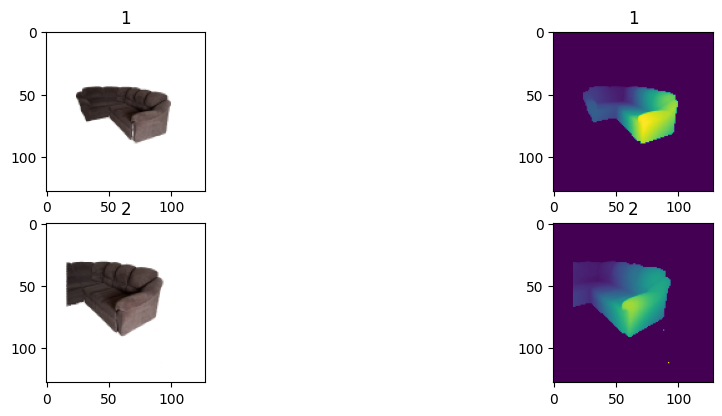

In [41]:
from PIL import Image
import cv2
from pillow_heif import register_heif_opener

register_heif_opener()

target_wh = 128, 128
is_lidar = True

indx_load = [1, 2, 3]

all_img_view = []
all_depth_view = []
all_prepared_img_view = []

for indx in indx_load:
    filename_path = './rgbd_imgs/divan/IMG_' + str(indx).zfill(4)
    if is_lidar:
        depth_loaded = Image.open(filename_path + '_depth.TIF')
        depth_loaded = depth_loaded.transpose(Image.Transpose.ROTATE_270)
        img_loaded = Image.open(filename_path + '.HEIC')
        img_loaded = img_loaded.resize(depth_loaded.size)
        mask_loaded = np.load(filename_path + '_mask.npy')
    else:
        assert 1 == 3, 'update it later to load properly...'
        img_loaded = np.load(filename_path + '_rgb.npy')[:, :, ::-1]
        depth_loaded = np.load(filename_path + '_depth.npy')[:, :, None].repeat(3, axis=-1)
        mask_loaded = np.load(filename_path + '_mask.npy')

    def resize_img(in_img, target_wh=(128, 128), scale_background=255):
        img = np.ones((target_wh[1], target_wh[0], in_img.shape[2] if len(in_img.shape) == 3 else 1), dtype=in_img.dtype) * scale_background
        if in_img.shape[0] > in_img.shape[1]:
            res_wh = (
                int(in_img.shape[1] / (in_img.shape[0] // target_wh[0])), 
                target_wh[1]
            )
        else:
            res_wh = (
                target_wh[0],
                int(in_img.shape[0] / (in_img.shape[1] // target_wh[1])), 
            )

        additional_shift_wh = (
            (target_wh[0] - res_wh[0])//2,
            (target_wh[1] - res_wh[1])//2
        )

        in_img = cv2.resize(in_img, res_wh, interpolation=cv2.INTER_AREA)
        if len(in_img.shape) == 2:
            in_img = in_img[:, :, None]
        img[additional_shift_wh[1]: res_wh[1]+additional_shift_wh[1], additional_shift_wh[0]: res_wh[0] + additional_shift_wh[0]] = in_img
        return img
    img_np = np.array(img_loaded)
    img_np[~mask_loaded] = 255 # Background white

    depth = np.array(depth_loaded, dtype=np.float32)

    mask_loaded = mask_loaded.astype(np.uint8)
    mask_loaded[mask_loaded == True] = 255

    img_np = resize_img(img_np, target_wh=target_wh, scale_background=255)
    depth = resize_img(depth[:, :, None], target_wh=target_wh, scale_background=0)
    mask = resize_img(mask_loaded[:, :, None], target_wh=target_wh, scale_background=0)
    mask[mask > 0] = 1
    mask = mask.astype(bool)

    depth_background_mask = ~mask.copy()
    depth_object_mask = mask.copy()
    # There are some cases, when object mask could be empty
    # Some broken objects or bad views are could present in the dataset
    if np.any(depth_object_mask):
        depth_object_values = depth[depth_object_mask]
        depth[depth_object_mask] = (depth_object_values - depth_object_values.mean()) / (depth_object_values.std() + 1e-8)
        # Background must be far away, so its just max value of the depth
        # TODO: Is it best way to handle that?
        depth[depth_background_mask] = depth[depth_object_mask].min()
        #depth = -depth # Invert it, to be from positive (close to camera) to negative (far away)
    else:
        # If object is not presented, when give just depth with zeros
        depth[...] = 0.0
        
    all_img_view.append(img_np.copy())
    all_depth_view.append(depth.copy())

    img_np = img_np.astype(np.float32)
    img_np /= 255.0
     
    image = np.concatenate([img_np, depth], axis=-1)
    image = np.transpose(image, (-1, 0, 1))
    all_prepared_img_view.append(image)

fig = plt.figure(figsize=(12, 12))
for i in range(1, len(all_img_view)):
    ax = fig.add_subplot(5,2,i*2-1)
    plt.imshow(all_img_view[i-1])
    plt.title(i)
    
    ax = fig.add_subplot(5,2,i*2)
    plt.imshow(np.squeeze(all_depth_view[i-1]))
    plt.title(i)

(64,
 20000,
 (-0.5, 0.5),
 0.01,
 '04256520/db7851745fb04cf732388c13cc4a0ba3',
 True)

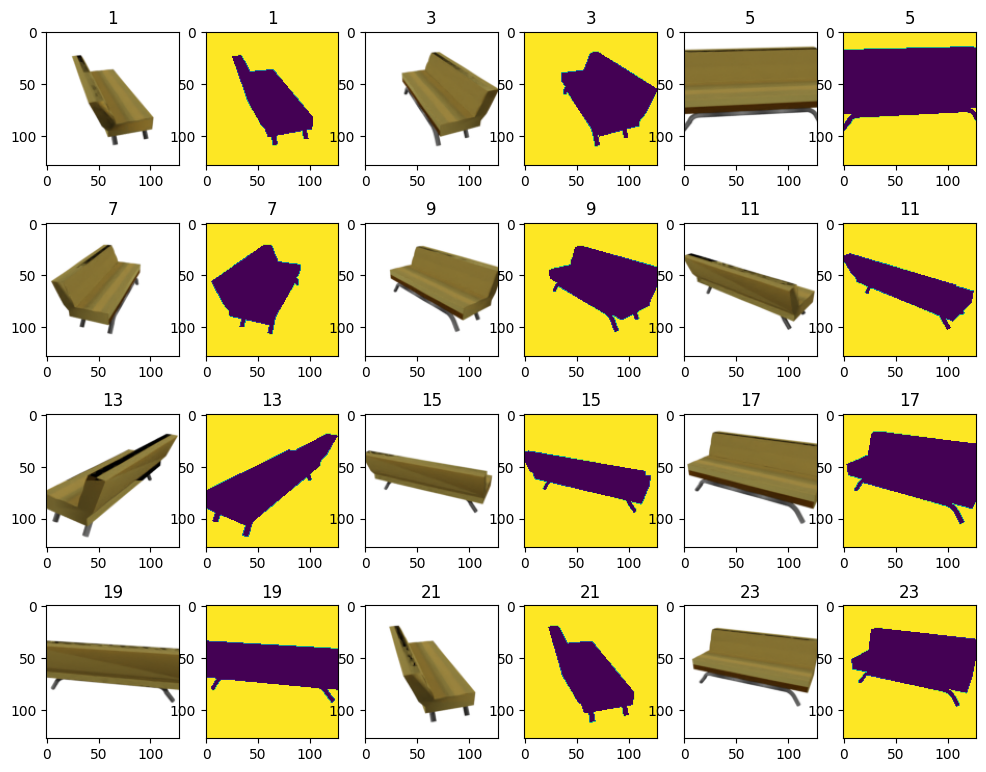

In [14]:
indx = 0
obj_indx = 6
find_obj_name = '04256520/db7851745fb04cf732388c13cc4a0ba3'
# '03001627/d16b62da42fa61f0cbce248a4e686c70'
# '04256520/db7851745fb04cf732388c13cc4a0ba3' 
# '03001627/d66b701631851e7b4b19d2c99e22ffe0'
# '04256520/db7851745fb04cf732388c13cc4a0ba3'
# '02691156/fb0f2907b977e7cb67c5e3041553656b' 
# '03001627/d16b62da42fa61f0cbce248a4e686c70'

img, resolution, max_batch, space_range, thresh, obj_path, sur_point, indx_sample = final_args[indx][0][obj_indx]

if find_obj_name is not None:
    indx_sample = samples.obj_paths.index(find_obj_name)
    img = samples.data_pixels[indx_sample, 0]
    obj_path = find_obj_name
    
gt_voxel, gt_points, gt_values, gt_class = (
    samples.data_voxels[indx_sample], 
    samples.data_points[indx_sample], 
    samples.data_values[indx_sample],
    samples.data_classes[indx_sample]
)
net_path, conf_path = final_args[indx][1:-1]

all_img_view = samples.data_pixels[indx_sample].copy()
all_depth_view = samples.data_depths[indx_sample].copy()

all_prepared_img_view = []
for i in range(len(all_img_view)):
    img_s = all_img_view[i]
    if samples.use_depth:
        depth = all_depth_view[i].copy()
        depth_background_mask = depth > 1_000
        depth_object_mask = ~depth_background_mask
        # There are some cases, when object mask could be empty
        # Some broken objects or bad views are could present in the dataset
        if np.any(depth_object_mask):
            depth_object_values = depth[depth_object_mask]
            depth[depth_object_mask] = (depth_object_values - depth_object_values.mean()) / (depth_object_values.std() + 1e-8)
            # Background must be far away, so its just max value of the depth
            # TODO: Is it best way to handle that?
            depth[depth_background_mask] = depth[depth_object_mask].max()
            depth = -depth # Invert it, to be from positive (close to camera) to negative (far away)
        else:
            # If object is not presented, when give just depth with zeros
            depth[...] = 0.0
        image = np.concatenate([img_s.copy() / 255.0, depth], axis=0)
    all_prepared_img_view.append(image)

fig = plt.figure(figsize=(12, 12))
for i in range(1, len(all_img_view), 2):
    ax = fig.add_subplot(5,6,i)
    plt.imshow(all_img_view[i-1].transpose(1,2,0))
    plt.title(i)
    
    ax = fig.add_subplot(5,6,i+1)
    plt.imshow(np.squeeze(all_depth_view[i-1]))
    plt.title(i)
    

resolution, max_batch, space_range, thresh, obj_path, sur_point

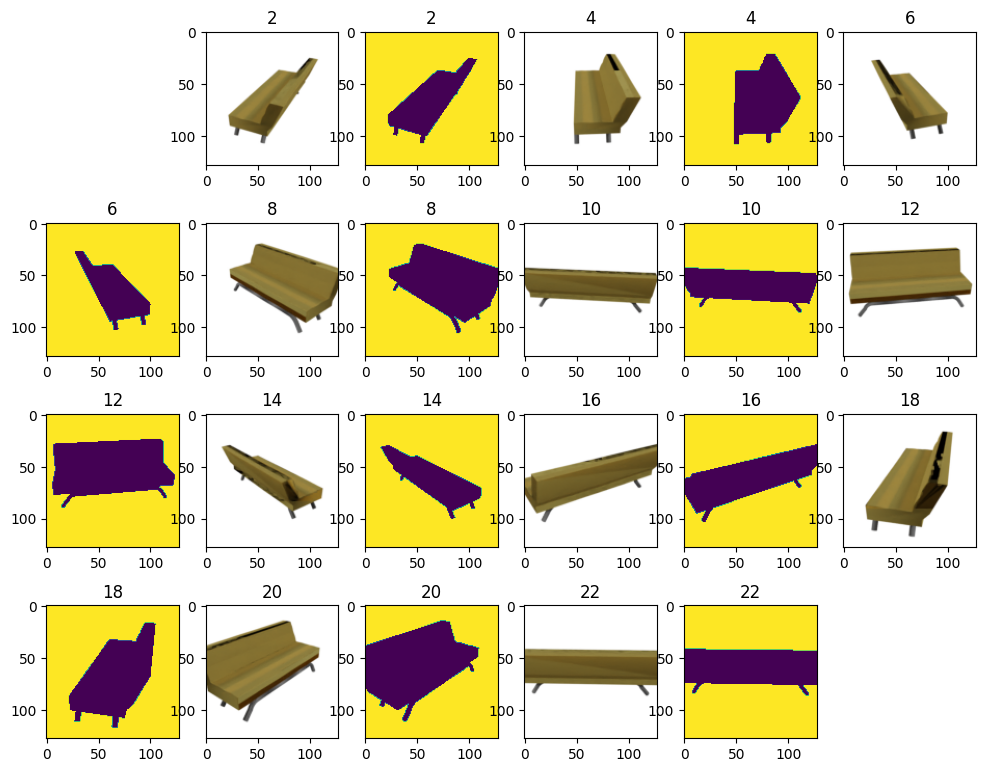

In [15]:
fig = plt.figure(figsize=(12, 12))
for i in range(2, len(all_img_view), 2):
    ax = fig.add_subplot(5,6,i)
    plt.imshow(all_img_view[i-1].transpose(1,2,0))
    plt.title(i)
    
    ax = fig.add_subplot(5,6,i+1)
    plt.imshow(np.squeeze(all_depth_view[i-1]))
    plt.title(i)

In [21]:
all_emb = []
for img_prep_s in all_prepared_img_view:
    with torch.no_grad():
        img_torch = torch.from_numpy(img_prep_s).float().to(device)
        embedding = network(img_torch.unsqueeze(0))
        all_emb.append(embedding)
all_emb = torch.stack(all_emb, dim=0)

In [22]:
!rm ./test_mean_ply/*

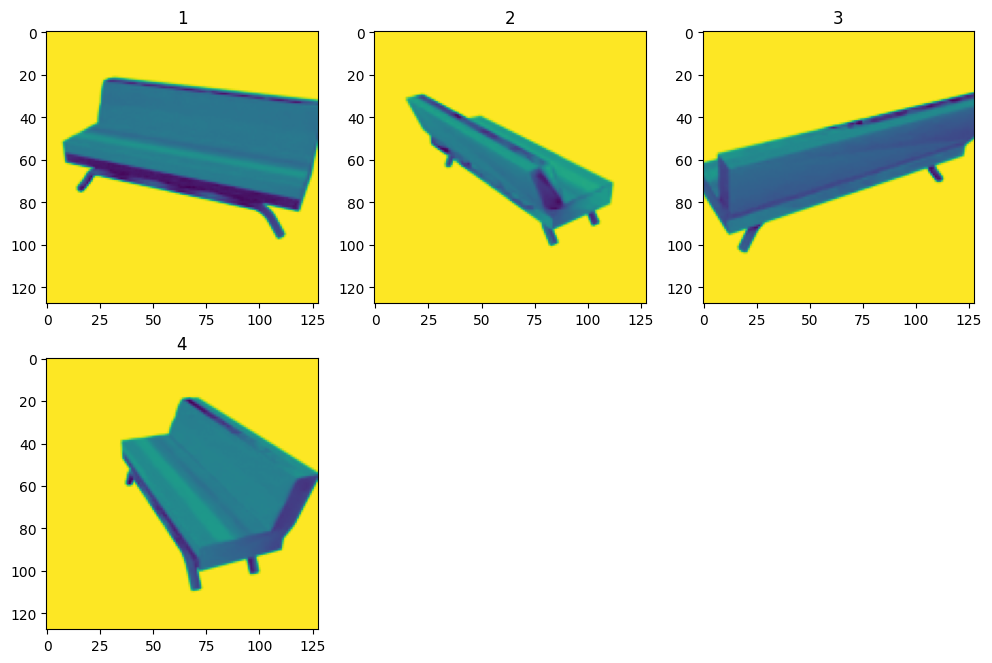

In [23]:
from utils.other_utils import write_ply_polygon

indx = [22, 13, 15, 2] # [0, 14, 22] list(range(len(all_img_view)))14
save_each = True
show_each = True
thershold_1=thershold
thershold_2=0.01
space_range = (-0.5, 0.5)
max_batch = 20_000

if isinstance(indx, list):
    embeddings = all_emb[indx].clone()
    if save_each:
        for indx_s, embedding in zip(indx, embeddings):
            (vertices, polygons, vertices_deformed, polygons_deformed, 
             embedding, vertices_convex, bsp_convex_list, pd_class,
             convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
                inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
                space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
            )
            write_ply_polygon(f'test_mean_ply/mesh_deformed_{indx_s}.ply', vertices_deformed, polygons_deformed)
            write_ply_polygon(f'test_mean_ply/mesh_orginal_{indx_s}.ply', vertices, polygons)
    
    embedding = embeddings.mean(dim=0)
    #embedding, _ = embeddings.median(dim=0)
    (vertices, polygons, vertices_deformed, polygons_deformed, 
     embedding, vertices_convex, bsp_convex_list, pd_class,
     convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
        inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
        space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
    )
    write_ply_polygon(f'test_mean_ply/mesh_deformed_mean.ply', vertices_deformed, polygons_deformed)
    write_ply_polygon(f'test_mean_ply/mesh_orginal_mean.ply', vertices, polygons)
    if show_each:
        fig = plt.figure(figsize=(12, 12))
        for i in range(1, len(indx)+1):
            ax = fig.add_subplot(3,3,i)
            plt.imshow(np.squeeze(all_img_view[indx[i-1]][0]))
            plt.title(i)
else:
    embedding = all_emb[indx] # 19 22
    (vertices, polygons, vertices_deformed, polygons_deformed, 
     embedding, vertices_convex, bsp_convex_list,
     convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
        inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
        space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
    )
    write_ply_polygon('test_mean_ply/mesh_deformed.ply', vertices_deformed, polygons_deformed)
    write_ply_polygon('test_mean_ply/mesh_orginal.ply', vertices, polygons)
    plt.imshow(np.squeeze(all_img_view[indx])[0])
    

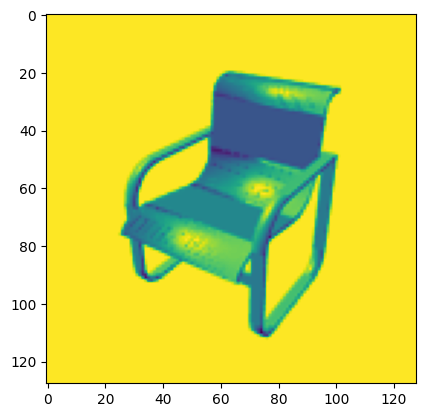

In [8]:
img = all_img_view[20] / 255.0
plt.imshow(img[0])

In [9]:
if is_svr:
    embedding = network(torch.from_numpy(img).float().to(device).unsqueeze(0))
    #embedding = voxel_auto_encoder(torch.from_numpy(gt_voxel).float().to(device).unsqueeze(0))
else:
    embedding = network(torch.from_numpy(gt_voxel).float().to(device).unsqueeze(0))
embedding.shape

torch.Size([1, 384])

In [83]:
thershold_1=thershold
thershold_2=0.01
space_range = (-0.5, 0.5)
max_batch = 20_000

(vertices, polygons, vertices_deformed, polygons_deformed, 
 embedding, vertices_convex, bsp_convex_list, pd_class,
 convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
    inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
    space_range=space_range, thershold_1=thershold, embedding=all_emb[0], save_output=False, return_voxel_and_values=True
)

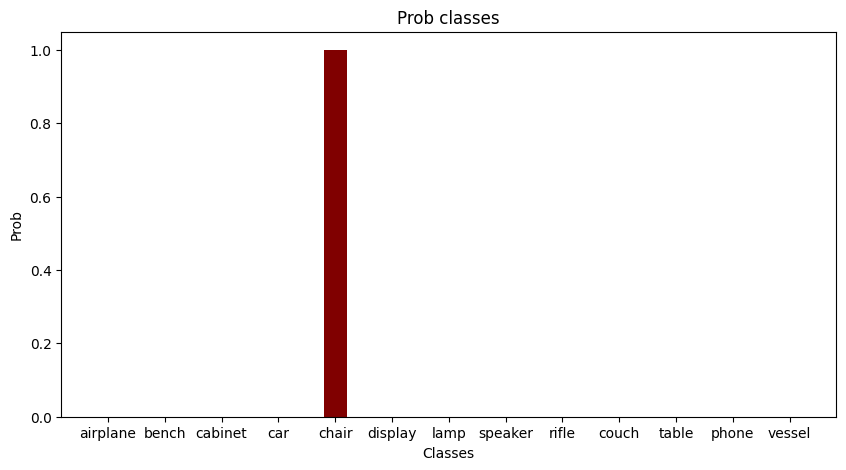

In [84]:
from evaluation.eval_utils import class_id_and_name_list
from scipy.special import softmax

class_probs = softmax(pd_class)
indx_class = np.argmax(pd_class)
class_id_and_name_list[indx_class]

# creating the dataset
data = dict(zip(
    map(lambda x: x.split('_')[-1], class_id_and_name_list), 
    class_probs
))
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("Prob")
plt.title("Prob classes")
plt.show()

In [86]:
from utils.other_utils import write_ply_polygon

write_ply_polygon('mesh_deformed.ply', vertices_deformed, polygons_deformed)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)